**Imports**

In [34]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tarfile as tarf
import os
from PIL import Image
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, AvgPool2D

**Downloading dataset**

In [35]:
!wget -q https://www.dropbox.com/s/lrplwf8dturn43p/CNN_dataset.tar.xz

**Unzip The dataset**

In [36]:
dataSet = tarf.open("CNN_dataset.tar.xz")
dataSet.extractall()
dataSet.close()

**Read all The images from the dataset**

In [37]:
dataFolder = './CNN_dataset/'
classNames = sorted([x for x in os.listdir(dataFolder) if os.path.isdir(os.path.join(dataFolder, x))])
classCount = len(classNames)
imageFiles = [[os.path.join(dataFolder, className, x) 
                for x in os.listdir(os.path.join(dataFolder, className))] 
               for className in classNames]
imageFileList = []
imageLabelList = []
for i, className in enumerate(classNames):
    imageFileList.extend(imageFiles[i])
    imageLabelList.extend([i] * len(imageFiles[i]))
totalNum = len(imageFileList)

# Total Images, Label Names and Counts.
print('Total Images:', totalNum)
print("Label Names:", classNames)
print("Label Counts:", [len(imageFiles[i]) for i in range(classCount)])

Total Images: 50000
Label Names: ['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label Counts: [10000, 10000, 10000, 10000, 10000]


**Dataset Sample**

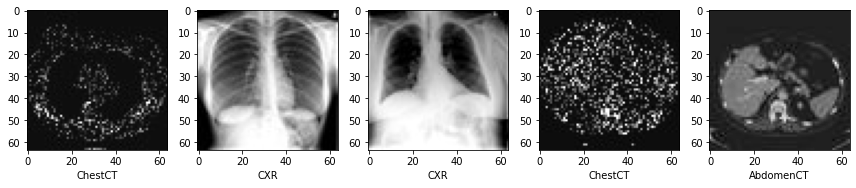

In [38]:
plt.subplots(1, 5, figsize=(12, 12))

# Randomly picked 5 examples of sample data.
for i,k in enumerate(np.random.randint(totalNum, size=5)):
    img = Image.open(imageFileList[k])
    arr = np.array(img)
    plt.subplot(1, 5, i + 1)
    plt.xlabel(classNames[imageLabelList[k]])
    plt.imshow(arr, cmap='gray')
plt.tight_layout()
plt.show()

**Prepare Dataset for Training and Testing** 



In [39]:
# Randomly select 85% for training 15% for Testing. we'll take 15% data from training for validation later.

testFracData = 0.15
trainX, trainY = [], []
testX, testY = [], []

for i in range(totalNum):
    ran = np.random.random()
    if ran < testFracData:
        testX.append(cv2.imread(imageFileList[i]))
        testY.append(imageLabelList[i])
    else:
        trainX.append(cv2.imread(imageFileList[i]))
        trainY.append(imageLabelList[i])

print(" For Training data =",len(trainX), "\n For Testing data =",len(testX))

 For Training data = 42588 
 For Testing data = 7412


**Process Data**

In [40]:
print(imageFileList[30000])
print(imageLabelList[30000])
classNames

./CNN_dataset/Hand/007188.jpeg
3


['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [41]:
trainX = np.array(trainX)
trainY = np.array(trainY)
testX  = np.array(testX)
testY  = np.array(testY)
print(type(trainX))

trainY = to_categorical(trainY, classCount)
testY = to_categorical(testY, classCount)
testY

<class 'numpy.ndarray'>


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [42]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
print("trainX shape:", trainX.shape, "train shape:", trainY.shape)

trainX shape: (42588, 64, 64, 3) train shape: (42588, 5)


**Building Model**

In [43]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2,2),strides=(1, 1), padding='same', activation='relu', input_shape=(64,64,3))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                2097216   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [44]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

**Model Training**

In [45]:
modelLog=model.fit(trainX, trainY,
          batch_size=60,
          epochs=5,
          verbose=1,
          validation_split=.15)

Epoch 1/5
604/604 [==============================] - 8s 10ms/step - loss: 0.1900 - accuracy: 0.9304 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/5
604/604 [==============================] - 5s 8ms/step - loss: 0.0583 - accuracy: 0.9814 - val_loss: 3.6687e-04 - val_accuracy: 1.0000
Epoch 3/5
604/604 [==============================] - 5s 8ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 6.8716e-05 - val_accuracy: 1.0000
Epoch 4/5
604/604 [==============================] - 5s 8ms/step - loss: 0.0376 - accuracy: 0.9859 - val_loss: 4.9672e-05 - val_accuracy: 1.0000
Epoch 5/5
604/604 [==============================] - 5s 8ms/step - loss: 0.0314 - accuracy: 0.9878 - val_loss: 1.7729e-05 - val_accuracy: 1.0000


**Evalute the Model on test dataset**

In [46]:
# make predictions on a test set
testPred = model.predict(testX)
testPredLabels = np.argmax(testPred, axis=1)
testTrueLabels = np.argmax(testY, axis=1)

# calculate confusion matrix
confusionMatrix = confusion_matrix(testTrueLabels, testPredLabels)

print(confusionMatrix)

232/232 [==============================] - 1s 3ms/step
[[1457    0    0    0    0]
 [   0 1449    0    4    0]
 [   0    0 1524    0    0]
 [   0    1    0 1479    0]
 [   0    0    0    0 1498]]


In [47]:
print(classification_report(testTrueLabels,testPredLabels, target_names=classNames,digits=5))

              precision    recall  f1-score   support

   AbdomenCT    1.00000   1.00000   1.00000      1457
         CXR    0.99931   0.99725   0.99828      1453
     ChestCT    1.00000   1.00000   1.00000      1524
        Hand    0.99730   0.99932   0.99831      1480
      HeadCT    1.00000   1.00000   1.00000      1498

    accuracy                        0.99933      7412
   macro avg    0.99932   0.99931   0.99932      7412
weighted avg    0.99933   0.99933   0.99933      7412

